# Hyper-parameter 최적화 - Wine Qauality
#### 작성: 고우주 | kubwa 쿱와

## 1-Import Packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## 2-Read the data

In [2]:
data = pd.read_csv('data/winequality-red.csv', encoding='utf8')
data.shape

(1599, 12)

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [5]:
# Making binary classificaion for the response variable.
bins = (2, 6.5, 8)
group_names = [0, 1] # 0:Bad, 1:Good
data['quality'] = pd.cut(data['quality'], bins=bins, labels=group_names)

In [6]:
print(data['quality'].value_counts())

0    1382
1     217
Name: quality, dtype: int64


In [7]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


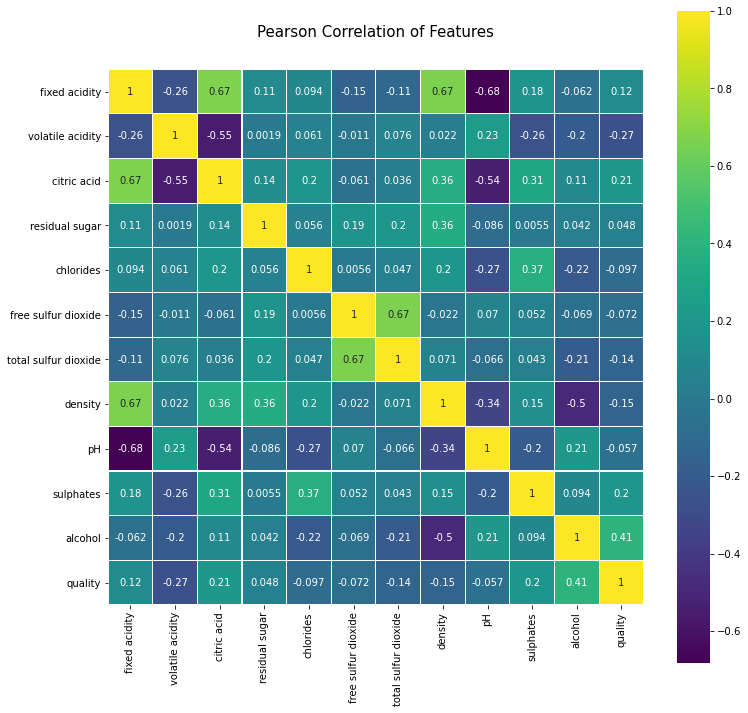

In [8]:
colormap = plt.cm.viridis

plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', 
          y=1.05, 
          size=15)
sns.heatmap(data.astype(float).corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True);

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from xgboost import XGBClassifier

## 2-Split the data

In [10]:
X = data.drop('quality', axis=1)
y = data['quality']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1279, 11)
(1279,)
(320, 11)
(320,)


## 3-Standardize Scale

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
def get_best_score(model):
    
    print(model.best_score_)
    print(model.best_params_)
    print(model.best_estimator_)
    
    return model.best_score_

## 4-Parameter tuning `GridSearchCV`

### XGBoost

https://xgboost.readthedocs.io/en/latest/parameter.html

> 주요 Hyper-parameter
- max_depth: 개별 나무의 깊이 (나무를 대충하기 위해 작은값)
- learning_rate: Boosting 단계 별로 가중치를 두는 학습율
- n_estimators: 나무의 수
- subsample: 각 나무를 학습할 때 사용하는 포인트 수의 비율 (0 초과 1 이하의 숫자로 비율 설정)
- colsample_bytree: 각 나무에서 사용하는 features 수의 비율 (0 초과 1 이하의 숫자로 비율 설정)
- gamma: 각 나무에서 분할하는데 필요한 최소 손실감소량
- reg_lambda: 각 나무에 배정되는 weights에 대하여 L2-regularization 강도

In [14]:
param_grid = {
    'max_depth': [3, 10],
    'learning_rate': [0.001, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.7, 0.8],
    'reg_lambda': [0.01, 0.1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0.1, 0.9]
}

In [15]:
xgb = XGBClassifier(random_state=1234)
xgb_grid = GridSearchCV(estimator=xgb, 
                        param_grid=param_grid, 
                        cv=5, 
                        verbose=2, 
                        n_jobs=-1)

xgb_grid.fit(X_train, y_train)
get_best_score(xgb_grid);

Fitting 5 folds for each of 128 candidates, totalling 640 fits
[21:29:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9069485294117647
{'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'reg_lambda': 0.01, 'subsample': 0.7}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
       

In [16]:
y_pred_grid = xgb_grid.predict(X_test)

print('<Confusion Matrix>')
print(metrics.confusion_matrix(y_test, y_pred_grid))
print('=' * 60)
print('<Classification Report>')
print(metrics.classification_report(y_test, y_pred_grid))
print('=' * 60)
print('<AUC>')
print(metrics.roc_auc_score(y_test, y_pred_grid))

<Confusion Matrix>
[[262  17]
 [ 17  24]]
<Classification Report>
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       279
           1       0.59      0.59      0.59        41

    accuracy                           0.89       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.89      0.89      0.89       320

<AUC>
0.7622169770084798


## 5-Parameter tuning `RandomSearchCV`

In [17]:
xgb = XGBClassifier(random_state=1234)
xgb_rand = RandomizedSearchCV(xgb, 
                        param_grid, 
                        cv=5, 
                        verbose=2, 
                        n_jobs=-1)

xgb_rand.fit(X_train, y_train)
get_best_score(xgb_rand);

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[21:30:03] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9069485294117647
{'subsample': 0.7, 'reg_lambda': 0.01, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1,
         

In [18]:
y_pred_rand = xgb_rand.predict(X_test)

print('<Confusion Matrix>')
print(metrics.confusion_matrix(y_test, y_pred_rand))
print('=' * 60)
print('<Classification Report>')
print(metrics.classification_report(y_test, y_pred_rand))
print('=' * 60)
print('<AUC>')
print(metrics.roc_auc_score(y_test, y_pred_rand))

<Confusion Matrix>
[[262  17]
 [ 17  24]]
<Classification Report>
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       279
           1       0.59      0.59      0.59        41

    accuracy                           0.89       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.89      0.89      0.89       320

<AUC>
0.7622169770084798


## 6-Parameter tuning `BayesianOptimization`
- https://github.com/fmfn/BayesianOptimization

In [19]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [20]:
#!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [21]:
def xgb_cv(max_depth, 
           learning_rate, 
           n_estimators, 
           subsample, 
           reg_lambda,
           colsample_bytree,
           gamma
          ):
    
    xgb = XGBClassifier(n_jobs=-1,
                        max_depth=int(max_depth),
                        learning_rate=learning_rate,
                        n_estimators=int(n_estimators),
                        subsample=subsample,
                        reg_lambda=reg_lambda,
                        random_state=1234,
                        colsample_bytree=colsample_bytree,
                        gamma=gamma
                       )
    
    return cross_val_score(xgb, 
                           X_train, 
                           y_train, 
                           scoring='accuracy', cv=5).mean()

In [22]:
xgb_opt = BayesianOptimization(xgb_cv,
                                 {'max_depth': [3, 10],
                                  'learning_rate': [0.001, 0.1],
                                  'n_estimators': [100, 200],
                                  'subsample': [0.7, 0.8],
                                  'reg_lambda': [0.01, 0.1],
                                  'colsample_bytree': [0.8, 1],
                                  'gamma': [0.1, 0.9]
                                  }, random_state=1234)

In [23]:
xgb_opt.maximize(init_points=2, n_iter=5)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
[21:30:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:06] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:30:07] WARNING: /opt/concourse/worker/volumes/live/7a2

In [24]:
xgb_opt.max

{'target': 0.9053829656862746,
 'params': {'colsample_bytree': 0.901906281581881,
  'gamma': 0.29086878274934824,
  'learning_rate': 0.022759742562073675,
  'max_depth': 9.92119015791219,
  'n_estimators': 177.80348482535953,
  'reg_lambda': 0.02192797819941731,
  'subsample': 0.750392220529445}}

In [25]:
best_params = xgb_opt.max['params']
best_params

{'colsample_bytree': 0.901906281581881,
 'gamma': 0.29086878274934824,
 'learning_rate': 0.022759742562073675,
 'max_depth': 9.92119015791219,
 'n_estimators': 177.80348482535953,
 'reg_lambda': 0.02192797819941731,
 'subsample': 0.750392220529445}

In [26]:
best_params['max_depth']

9.92119015791219

In [27]:
xgb_bayes = XGBClassifier(max_depth=int(best_params['max_depth']),
                          learning_rate=best_params['learning_rate'],
                          n_estimators=int(best_params['n_estimators']),
                          reg_lambda=best_params['reg_lambda'],
                          subsample=best_params['subsample'])

In [28]:
xgb_bayes.fit(X_train, y_train)

[21:30:15] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.022759742562073675, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=177, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=0.02192797819941731, scale_pos_weight=1,
              subsample=0.750392220529445, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [29]:
y_pred_bayes = xgb_bayes.predict(X_test)

print('<Confusion Matrix>')
print(metrics.confusion_matrix(y_test, y_pred_bayes))
print('=' * 60)
print('<Classification Report>')
print(metrics.classification_report(y_test, y_pred_bayes))
print('=' * 60)
print('<AUC>')
print(metrics.roc_auc_score(y_test, y_pred_bayes))

<Confusion Matrix>
[[262  17]
 [ 15  26]]
<Classification Report>
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       279
           1       0.60      0.63      0.62        41

    accuracy                           0.90       320
   macro avg       0.78      0.79      0.78       320
weighted avg       0.90      0.90      0.90       320

<AUC>
0.7866072209109188
